In [1]:
from pyspark import SparkContext, SparkConf
from pyspark import HiveContext
from pyspark.sql import SQLContext
import datetime
import pandas as pd
import numpy as np
import random
np.random.seed(5)
confs = SparkConf()
confs.set("spark.driver.maxResultSize","15g")
confs.set("spark.driver.memory","30g")
confs.set("spark.dynamicAllocation.enabled","true")
confs.set("spark.dynamicAllocation.minExecutors","1")
confs.set("spark.dynamicAllocation.maxExecutors","600")
confs.set("spark.task.maxFailures","15")
confs.set("spark.yarn.max.executor.failures","1000")
confs.set("spark.dynamicAllocation.executorIdleTimeout","400")
confs.set("spark.shuffle.service.enabled","true")
confs.set("spark.executor.cores","1")
confs.set("spark.executor.memory","8g")
confs.set("spark.network.timeout","240000")
confs.set("spark.akka.frameSize","512")
confs.set("spark.yarn.dist.archives","hdfs://cls04pri/user/vvelocci/RoutesNYC.zip#anaconda")
sc = SparkContext(conf=confs,master="yarn-client",pyFiles=['hdfs://cls04pri/user/vvelocci/routes/parsers.py', 'hdfs://cls04pri/user/vvelocci/poi/objects.py', 'hdfs://cls04pri/user/vvelocci/utils/globals.py'])                               
hc = HiveContext(sc)

In [2]:
#hc.sql("show databases").collect()

In [3]:
#import geopandas as gpd
import folium
from datetime import datetime
import dateutil.parser
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import os
import fiona
import json
import ast
import parsers
import objects as ob
from shapely.geometry import shape, Point, asShape
import time

In [23]:
# austin = fiona.open("austin/")
# austin_geojson = {"type" : "FeatureCollection" , "features" : list(austin)}
#kcmo = fiona.open("kansas_city_shapefile/")
#kc_geojson = {"type" : "FeatureCollection" , "features" : list(kcmo)}

In [3]:
roads = hc.read.parquet("hdfs://cls04pri/user/pdannamaneni/roads_20170430")#.sample(False, 0.1)#.select("saveformat")
#roads.count()
# 38501164

In [4]:
kcmo = fiona.open("kansas_city_shapefile/kansas_city_shapefile.shp")
foo = kcmo.next()
kcmo_geometry = shape(foo['geometry'])
kcmo_simple = kcmo_geometry.buffer(0.5)
city = sc.broadcast(kcmo_simple)

In [5]:
#kcmo_simple = kcmo_geometry.simplify(0.00025)

In [6]:
print kcmo_geometry.area, kcmo_simple.area, len(kcmo_geometry.exterior.coords), len(kcmo_simple.exterior.coords)

0.0808300931503 1.65584343562 637 139


In [7]:
kcmo_simple.area - kcmo_geometry.area

1.5750133424678294

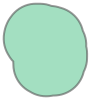

In [8]:
kcmo_simple

In [9]:
g = Point(39.093468,-94.418866)

In [10]:
kcmo_simple.intersects(g)

False

In [11]:
def geom_location2(x):
    geometries = x[1]
    geometries = [geometry for geometry in geometries if geometry['properties']['geom_type'] == 'Location']
    return (x[0], geometries)
def in_kcmo2(x):
    geometries = x[1]
    user = x[0]
    geometries = [geometry for geometry in geometries if asShape(geometry['geometry']).intersects(city.value)]
    return (user, geometries)
def combine(a,b):
    a.extend(b)
    return a

In [12]:
# Filtering locations to those in KCMO, while keeping sub_id.  ReduceByKey on sub_id.  Used to generate a pickle file
roads_list = roads.map(list).map(lambda x: (x[1], ast.literal_eval(x[0])['locations'])).map(geom_location2).map(in_kcmo2).filter(lambda x: len(x[1]) > 0).reduceByKey(combine)

In [13]:
import pickle
with open('kcmo_locations_with_subid.pickle', 'wb') as handle:
    pickle.dump(roads_list.collect(), handle)

In [15]:
roads_list.saveAsTextFile("hdfs://cls04pri/user/vvelocci/locations_in_kcmo_by_subid.txt")

In [ ]:
#---------------------------MISC STUFF BELOW--------------------------------

In [ ]:
# sum = 0
# for entry in roads_list.collect():
#     sum += len(entry[1])
# sum
# #1012366

In [80]:
# Converting to shapely objects and filtering them.  Not used to generate the pickle file (doesn't work).
from shapely.geometry import asShape
city = sc.broadcast(kcmo_simple)
def in_kcmo(x):
    if x.intersects(city.value):
        return True
    return False
def geom_location(x):
    if x['properties']['geom_type'] == 'Location':
        return True
    return False
roads_list = roads.map(list).map(lambda x: ast.literal_eval(x[0])).flatMap(lambda x: x['locations']).filter(geom_location).map(lambda x: asShape(x['geometry'])).filter(lambda x: in_kcmo(x))

In [9]:
# Converting to shapely objects, filtering them, then converting back to geojson.  Used to generate the pickle file.
from shapely.geometry import asShape
city = sc.broadcast(kcmo_simple)
def in_kcmo(x):
    if x.intersects(city.value):
        return True
    return False
def geom_location(x):
    if x['properties']['geom_type'] == 'Location':
        return True
    return False
roads_list = roads.map(list).map(lambda x: ast.literal_eval(x[0])).flatMap(lambda x: x['locations']).filter(geom_location).map(lambda x: (x,asShape(x['geometry']))).filter(lambda x: in_kcmo(x[1])).map(lambda x: x[0])

In [85]:
start_time = time.time()
x = roads_list.count()
elapsed_time = time.time() - start_time

In [83]:
# x, elapsed_time full sample
# (1012366, 1441.9119019508362)

In [76]:
#x, elapsed_time
#(843130, 484.6640930175781)

In [87]:
import pickle
with open('kcmo_locations.pickle', 'wb') as handle:
    pickle.dump(roads_list.collect(), handle)

In [88]:
file = open("kcmo_locations.pickle",'r')
locations = pickle.load(file)

In [98]:
len(locations)

1012366

In [95]:
roads_list.saveAsTextFile("hdfs://cls04pri/user/vvelocci/locations_in_kcmo.txt")

In [97]:
# n = 40000000
# numbers = list(range(n))
# i = -1
# def labels():
#     global i
#     global numbers
#     i += 1
#     return str(numbers[i])
# city = sc.broadcast(kcmo_simple)
# def in_kcmo(x):
#     if x.intersects(city.value):
#         return True
#     return False
# def geom_location(x):
#     if x['properties']['geom_type'] == 'Location':
#         return True
#     return False
# roads_list2 = roads_list.map(list).map(lambda x: ast.literal_eval(x[0])).flatMap(lambda x: x['locations']).filter(geom_location).map(lambda x: ob.Shape(labels(), x)).filter(lambda x: in_kcmo(x.geometry))
# #n = roads_list.count()
# # numbers = list(range(n))
# # i = -1
# # def labels():
# #     global i
# #     global numbers
# #     i += 1
# #     return str(numbers[i])
# # city = sc.broadcast(kcmo_simple)
# # def in_kcmo(x):
# #     if x.intersects(city.value):
# #         return True
# #     return False
# # locations_rdd = roads_list.map(lambda x: ob.Shape(labels(), x))
# # final_locations = locations_rdd.filter(lambda x: in_kcmo(x.geometry))
# start_time = time.time()
# x = roads_list2.count()
# elapsed_time = time.time() - start_time

In [35]:
# #kansas_city = ob.Shape('kcmo', kc_geojson['features'][0])
# city = sc.broadcast(kcmo_simple)
# locations_rdd2 = locations_rdd.map(lambda x: (x,ob.Shape(labels(), x)))
# def in_kcmo(x):
#     if x.intersects(city.value):
#         return True
#     return False
# final_locations = locations_rdd2.filter(lambda x: not in_kcmo(x[1].geometry))
# locations_in_kcmo = final_locations.map(lambda x: x[0])
# shapes_in_kcmo = final_locations.map(lambda x: x[1])
# #locations_in_kcmo.cache()

In [ ]:
#locations_rdd.unpersist()

In [ ]:
#data_sample = hc.read.parquet("data_sample")

In [ ]:
# sample = roads.sample(False,0.0000001)
# sample.cache()

In [ ]:
# from ctypes import *
# CDLL('hdfs://cls04pri/user/vvelocci/anaconda2/lib/')

In [11]:
#data = hc.read.parquet("hdfs://cls04pri/user/pdannamaneni/roads_20170430")
#data_sample = data.sample(False,0.001).select("saveformat")
#data_sample.cache()
#data_sample.count()
# 38585
#data_sample.coalesce(30).write.parquet("hdfs://cls04pri/user/vvelocci/data_sample")

In [3]:
#data_sample = hc.read.parquet("data_sample")

In [ ]:
"""
If you were using one of those shapefiles I linked too (there are a few options at different detail levels), 
you would download the zip, unzip it, and then load it with your package of choice (geopandas, fiona, pyshp, osgeo).
Personally, I’m a fan of geopandas.  Here’s how to pick out MD and VA using geopandas and save to a new shapefile:
import geopandas as gpd
states = gpd.read_file('/Users/alanschoen/Downloads/cb_2016_us_state_500k/cb_2016_us_state_500k.shp')
just_md_va = states[states.STUSPS.isin(['MD', 'VA'])]
just_md_va.to_file('just_md_va.shp', driver='ESRI Shapefile')
"""

In [6]:
#Convert Austin shapefile directory into geojson (or use method Alan provided for whole states)
#Filter roads_20170430 that only pass through Austin using Austin shapefile.
#Filter TX POI data that only passes through Austin.
#Maybe classify according to two methods:
# Method 1: Label the POI dataset, then use KNN for the location points.  Select K by dividing the labeled POI dataset
# into train and test sets, training on each K value and testing.
# Method 2: Classify on the clusters.  Cluster the location data according to the model from Prash and Jared, then
# apply KNN with the labeled POI set.
# But how do I label the POI dataset??

In [10]:
# states = gpd.read_file('/home/vvelocci/Classification/cb_2016_us_state_500k/cb_2016_us_state_500k.shp')
# tx = states[states.STUSPS.isin(['TX'])]
# mo = states[states.STUSPS.isin(['MO'])]
# ny = states[states.STUSPS.isin(['NY'])]
# tx.to_file('/home/vvelocci/Classification/tx/tx.shp', driver='ESRI Shapefile')
# mo.to_file('/home/vvelocci/Classification/mo/mo.shp', driver='ESRI Shapefile')
# ny.to_file('/home/vvelocci/Classification/ny/ny.shp', driver='ESRI Shapefile')

In [22]:
#poi_tx = pd.read_csv('IYP_TX.afi.txt', sep=" ", header = None)